# 신경망⋅ 딥러닝의 응용 (필기체 숫자 인식)

실질적으로 필기체 숫자를 피드 포워드 네트워크에 인식시켜본다.

## 8.1 MNIST DB

필기체 숫자 데이터 셋으로 케라스로 불러온다.

In [1]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


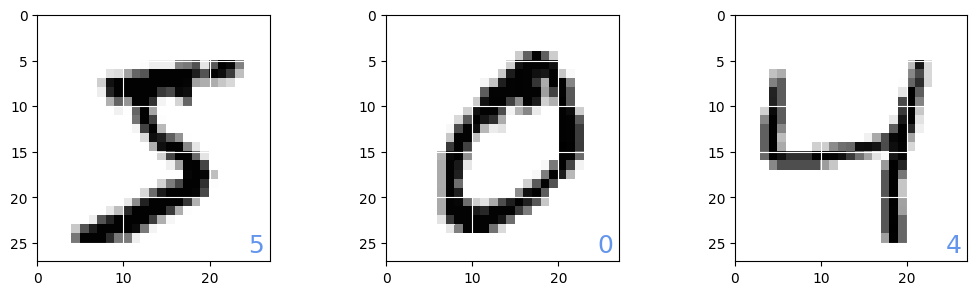

In [2]:
# 60000개 훈련데이터, 라벨 / 10000개 테스트 데이터
# x_train -> 60000 x 28 x 28의 배열 변수로, 각 요소는 0~255 값을 갖는 정수이다.
# 3개만 불러옴

import numpy as np
import matplotlib.pyplot as plt
plt.figure(1, figsize=(12, 3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()
for id in range(3):
  plt.subplot(1, 3, id+ 1)
  img = x_train[id, :, :]
  plt.pcolor(255 - img)
  plt.text(24.5, 26, "%d" % y_train[id],
           color= 'cornflowerblue', fontsize=18)
  plt.xlim(0, 27)
  plt.ylim(27, 0)
  plt.grid('on', color='white')
plt.show()

## 8.2 2층 피드 포워드 네트워크 모델

In [3]:
# 클래스 분류 문제가 해결되는지 확인해보기

from keras.utils import to_categorical

x_train = x_train.reshape(60000, 784)
#x_train = x_train.reshape(x_train.shape[0], -1)
x_train = x_train.astype('float32')
x_train = x_train / 255
num_classes = 10
# np_utils.to_categorical 이라는 케라스 함수를 사용하여 1-of-K 부호화법으로 변경함.
y_train = to_categorical(y_train, num_classes)
x_test = x_test.reshape(10000, 784)
#x_test = x_test.reshape(x_test.shape[0], -1)
x_test = x_test.astype('float32')
x_test = x_test / 255
# np_utils.to_categorical 이라는 케라스 함수를 사용하여 1-of-K 부호화법으로 변경함.
y_test = to_categorical(y_test, num_classes)



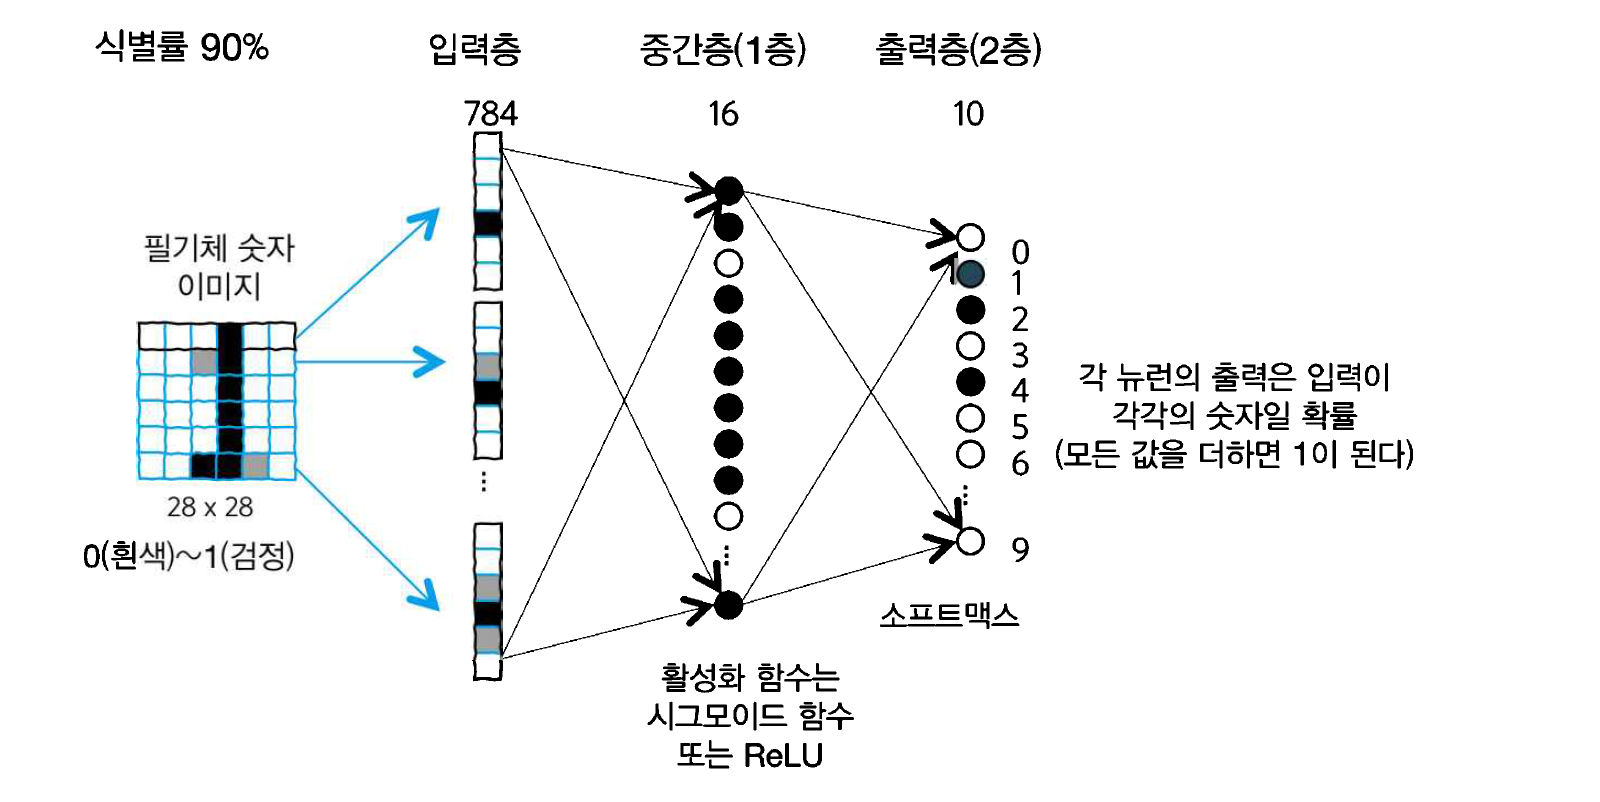

위와 같은 layer로 입력은 784차원의 벡터이며, 네트워크 출력층은 10개의 숫자를 분류할 수 있도록 10개로 구성. 또한 확률적인 요소를 넣기위해 소프트맥스함수 사용

입력과 출력을 연결하는 중간층은 16개, 활성화함수는 시그모이드로 정리함(확률적분포)

In [4]:
# layer 구성


np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(16, input_dim = 784, activation = 'sigmoid'))
model.add(Dense(10, activation = 'softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])


In [5]:
# 학습

import time

startTime = time.time()
history = model.fit(x_train, y_train, epochs=10, batch_size=1000, verbose=1, validation_data = (x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss :", score[0])
print("test accuracy :", score[1])
print("Computation time:{0:.3f} sec".format(time.time()- startTime))


Epoch 1/10
60/60 [==============================] - 3s 23ms/step - loss: 2.0137 - accuracy: 0.4476 - val_loss: 1.7433 - val_accuracy: 0.6464
Epoch 2/10
60/60 [==============================] - 1s 15ms/step - loss: 1.5719 - accuracy: 0.7008 - val_loss: 1.4078 - val_accuracy: 0.7552
Epoch 3/10
60/60 [==============================] - 1s 16ms/step - loss: 1.2884 - accuracy: 0.7825 - val_loss: 1.1657 - val_accuracy: 0.8166
Epoch 4/10
60/60 [==============================] - 1s 15ms/step - loss: 1.0780 - accuracy: 0.8264 - val_loss: 0.9843 - val_accuracy: 0.8489
Epoch 5/10
60/60 [==============================] - 1s 17ms/step - loss: 0.9197 - accuracy: 0.8512 - val_loss: 0.8469 - val_accuracy: 0.8676
Epoch 6/10
60/60 [==============================] - 1s 13ms/step - loss: 0.7993 - accuracy: 0.8650 - val_loss: 0.7419 - val_accuracy: 0.8777
Epoch 7/10
60/60 [==============================] - 1s 12ms/step - loss: 0.7065 - accuracy: 0.8742 - val_loss: 0.6610 - val_accuracy: 0.8860
Epoch 8/10
60

Loss function의 기울기를 갱신 1단계마다 계산하고 있다. 하지만 데이터가 크면 계산에 많은 시간이 걸린다. 그렇기에 확률적 경사 하강법이 사용되며, 1회 갱신에 사용되는 데이터의 크기는 배치크기로 정의하며 배치사이즈가 1000일 경우 갱신할 때 마다 다른 1000개의 데이터셋에서 기울기가 계산된 매개 변수라 갱신되어 간다.

그래서 기존과는 다르게 삐뚤삐뚤하면서 내려가는 것을 볼수 있고 기존의 경사하강법은 local minimum에 빠져나가기 힘든 것과 반면에 확률적 경사하강의 경우 업데이트 폭이 크기 때문에(휘청거리는 효과 덕분)에 벗어나기 유용하다.

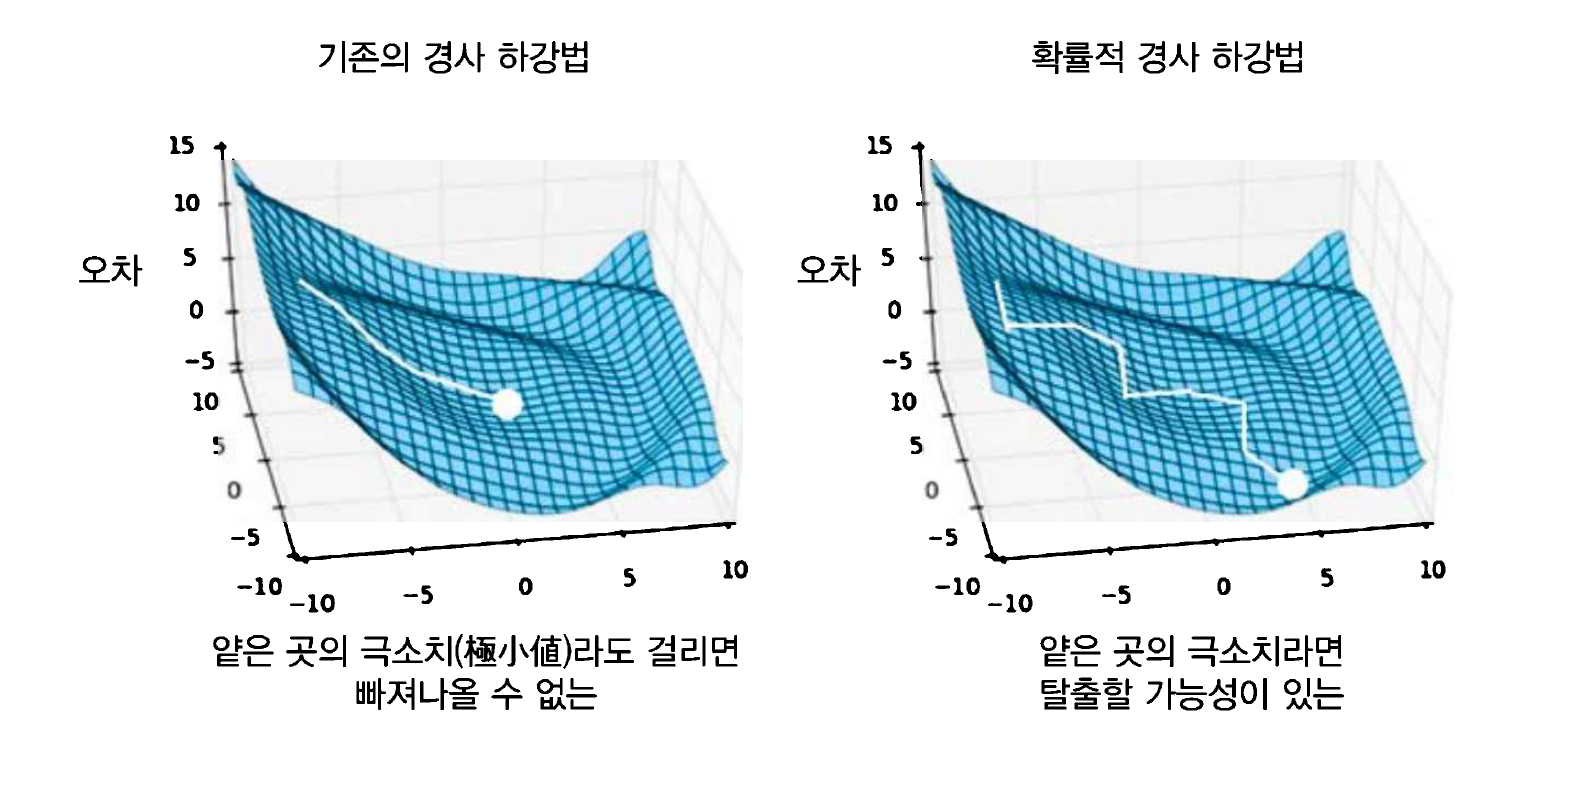

epoch -> 학습 갱신 횟수

ex) train_data_size = 60000, batch_size = 10000 -> 60회의 매개변수 갱신

nb_epoch = 10 -> 그의 10배 임으로 600회 매개변수 갱신

verbose = 1 -> 학습 과정의 표시 (학습의 진행상태, 매시기의 오차, 정밀도, 계산 시간이 표시)



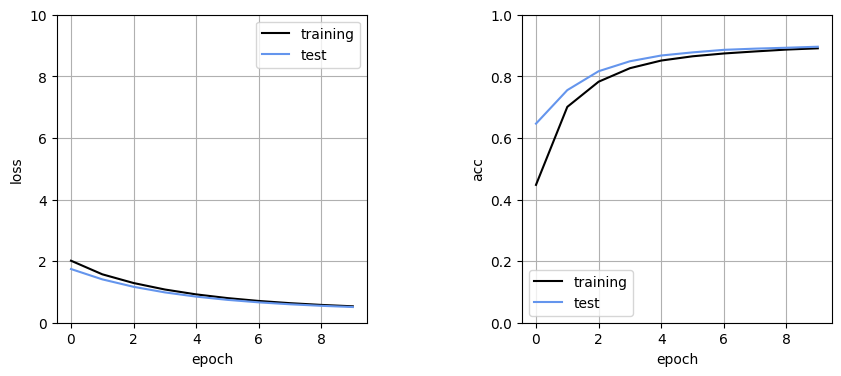

In [6]:
# 오버피팅의 확인을 위해, 테스트 데이터 오차의 시간 변화를 살펴보기

import numpy as np
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10,4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='training', color='black')
plt.plot(history.history['val_loss'], label='test', color='cornflowerblue')
plt.ylim(0, 10)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='training', color='black')
plt.plot(history.history['val_accuracy'], label='test', color='cornflowerblue')
plt.ylim(0 ,1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

313/313 [==============================] - 1s 4ms/step


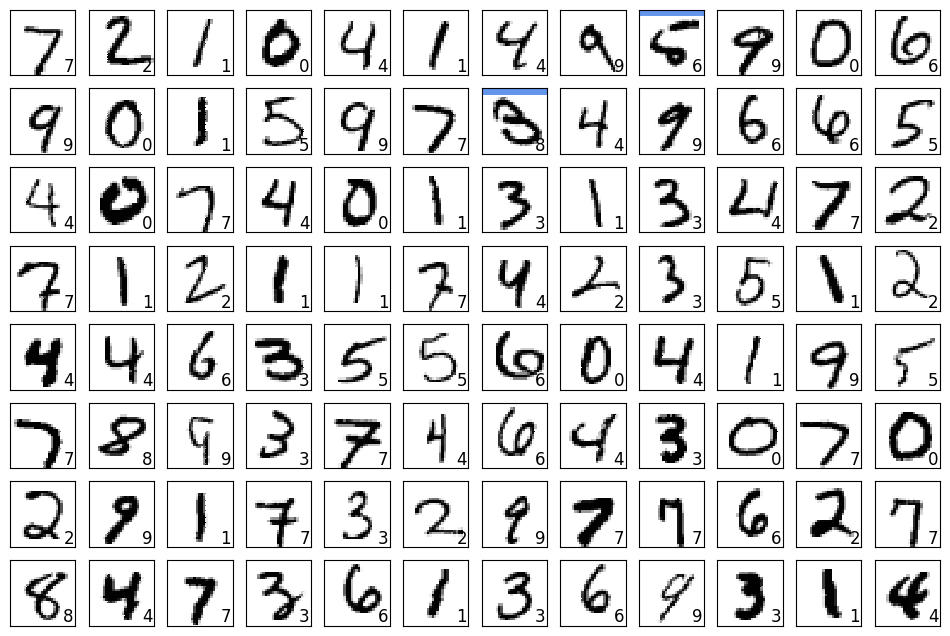

In [16]:
# 모델의 출력

def show_prediction():
  n_show = 96
  y = model.predict(x_test)
  plt.figure(2, figsize=(12, 8))
  plt.gray()
  for i in range(n_show):
    plt.subplot(8, 12, i+1)
    x = x_test[i, :]
    x = x.reshape(28, 28)
    plt.pcolor(1-x)
    wk = y[i, :]
    prediction = np.argmax(wk)
    plt.text(22, 25.5, "%d" % prediction, fontsize=12)
    if prediction != np.argmax(y_test[i, :]):
      plt.plot([0, 27], [1, 1], color='cornflowerblue', linewidth=5)
    plt.xlim(0, 27)
    plt.ylim(27, 0)
    plt.xticks([], "")
    plt.yticks([], "")

# 메인

show_prediction()
plt.show()

## 8.3 ReLU 활성화 함수

시그모이드 : x 가 어느정도 커지면 항상 1에 가까운 값을 출력 -> gradient vanishing

ReLU -> gradient vanishing의 문제를 어느정도 해결하며 계산이 빠르다.



In [8]:
# Sigmoid -> ReLU 변경

np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(16, input_dim = 784, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

# 학습

startTime = time.time()
history = model.fit(x_train, y_train, epochs=10, batch_size=1000, verbose=1, validation_data = (x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss :", score[0])
print("test accuracy :", score[1])
print("Computation time:{0:.3f} sec".format(time.time()- startTime))

Epoch 1/10
60/60 [==============================] - 1s 11ms/step - loss: 1.5895 - accuracy: 0.5003 - val_loss: 1.0013 - val_accuracy: 0.7439
Epoch 2/10
60/60 [==============================] - 0s 8ms/step - loss: 0.7529 - accuracy: 0.8047 - val_loss: 0.5520 - val_accuracy: 0.8571
Epoch 3/10
60/60 [==============================] - 0s 8ms/step - loss: 0.4889 - accuracy: 0.8742 - val_loss: 0.4161 - val_accuracy: 0.8897
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.3924 - accuracy: 0.8950 - val_loss: 0.3528 - val_accuracy: 0.9059
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.3444 - accuracy: 0.9056 - val_loss: 0.3195 - val_accuracy: 0.9140
Epoch 6/10
60/60 [==============================] - 1s 8ms/step - loss: 0.3163 - accuracy: 0.9129 - val_loss: 0.2975 - val_accuracy: 0.9173
Epoch 7/10
60/60 [==============================] - 0s 8ms/step - loss: 0.2945 - accuracy: 0.9180 - val_loss: 0.2806 - val_accuracy: 0.9221
Epoch 8/10
60/60 [=

313/313 [==============================] - 0s 1ms/step


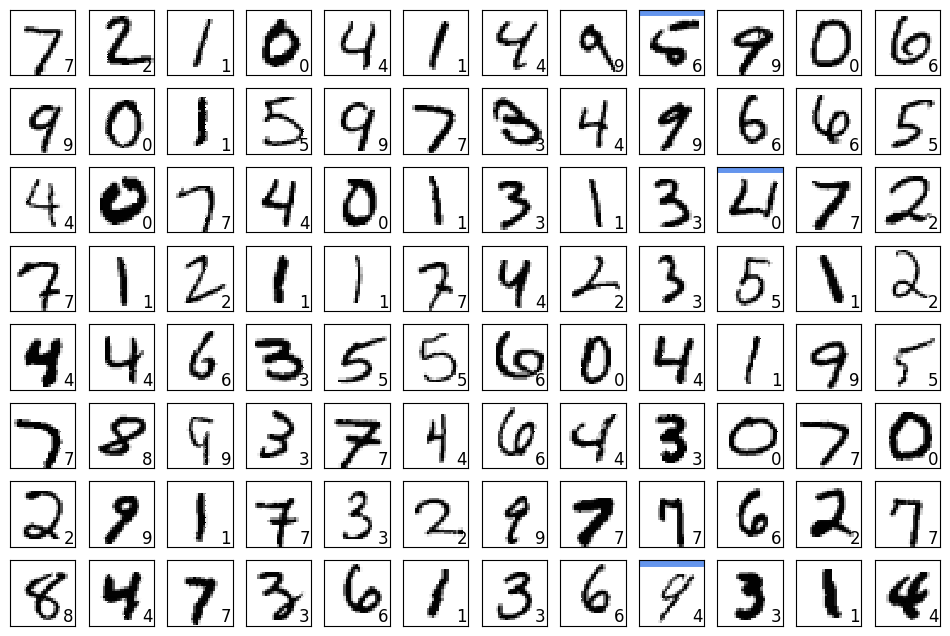

In [9]:
# 결과 출력

show_prediction()
plt.show()

acc -> 약 3% 상승함.

이 네트워크의 어떤 매개 변수를 획득했을지에 대해 도시화

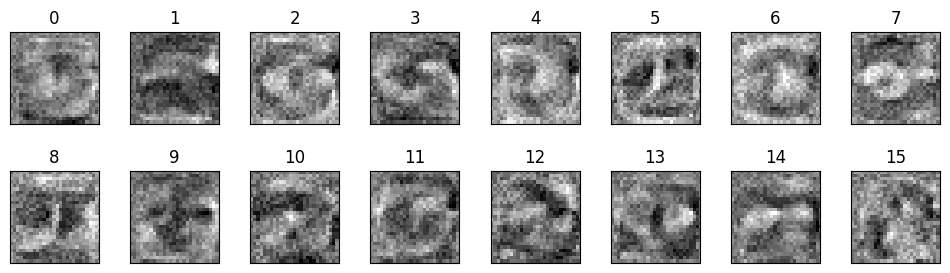

In [10]:
w = model.layers[0].get_weights()[0]
plt.figure(1, figsize=(12, 3))
plt.gray()
plt.subplots_adjust(wspace=0.35, hspace=0.5)
for i in range(16):
  plt.subplot(2, 8, i+1)
  w1 = w[:, i]
  w1 = w1.reshape(28, 28)
  plt.pcolor(-w1)
  plt.xlim(0, 27)
  plt.ylim(27, 0)
  plt.xticks([], "")
  plt.yticks([], "")
  plt.title("%d" %i)
plt.show()

여기서 네트워크가 학습 후 획득한 입력부터 중간층 뉴런까지의 가중치, 검은 부분이 양의 값을, 흰색 부분이 음의 값을 나타낸다.

검은 부분에 입력 이미지가 있으면 그 유닛은 활성화하고, 반대로 흰색 부분에 입력 이미지가 있는 유닛은 억제된다.

-> 검은 부분에 문자 일부분이 있으면 그 뉴런은 활성화하고 흰 부분에 문자 일부분이 있으면 억제된다.

하지만 이 모델에선 차원의 정보(공간 정보)를 전혀 사용하지 않았다.

화소가 정렬 순서는 네트워크 성능과 전혀 관계가 없다. 예를 들어 이미지 위치 (1,1) 위치의 픽셀값을 (3,5)의 픽셀 값으로 교환해도 동일한 정밀도로 학습할 수있다.

이렇게 변환을 계속해서 각각의 이미지가 마구 섞여도 성능이 변하지 않는다.



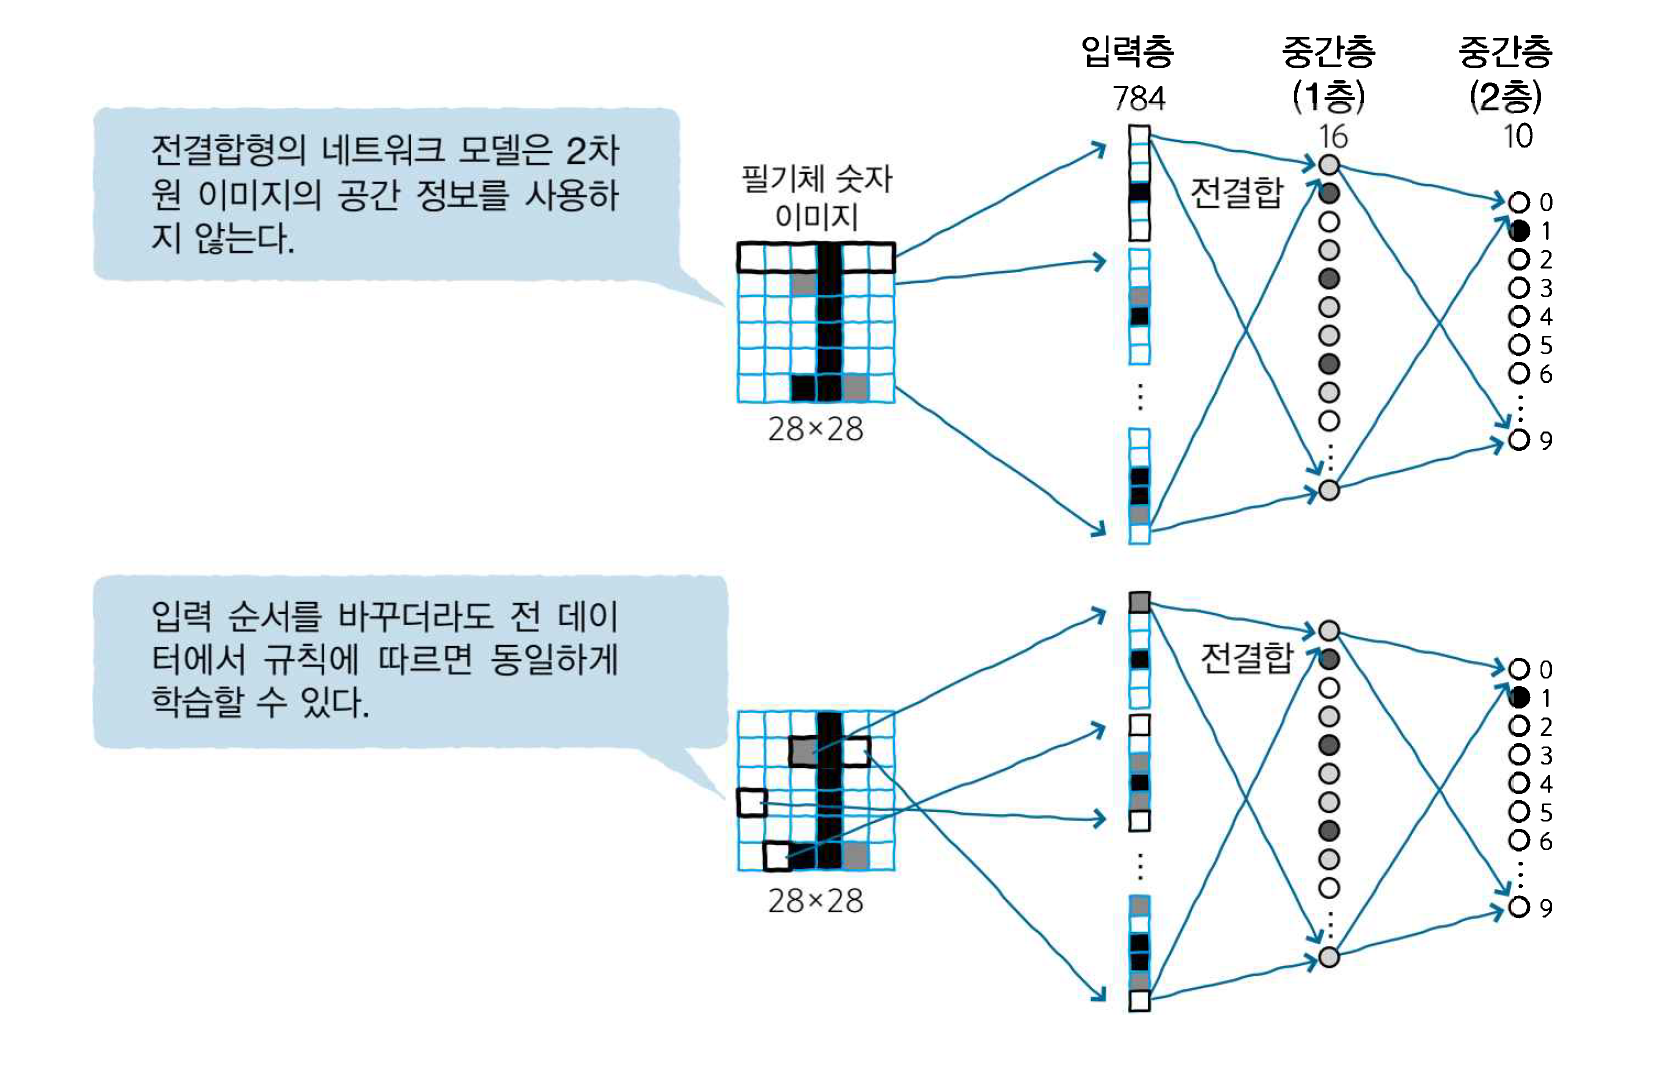

그 이유는 네트워크 구조가 전결합형이며 모든 입력 성분은 대등한 관계이기 때문이다.

그래서 실제 layer에서 보면 이웃에 있는 입력 성분도, 멀리 떨어진 입력 성분도 수식상은 똑같은 관계이다.

-> Input Image의 pixel값에 대해서 쭉 펼쳐 놓고 그 다음 layer에 그전의 모든 pixel값을 넘겨주기 때문에 위치정보가 사라지는 것이다.

## 8.4 공간 필터

공간 정보란 직선, 곡선 ,원형이나 사각형 같은 모양을 나타내는 정보이다.

이러한 형태를 골라 내는 방법으로 '공간 필터'라는 이미지 처리법이 있다.

2차원 행렬 필터로 이미지의 일부분과 필터 요소를 곱한 합을 이미지를 슬라이드 시키면서 이미지의 전 영역에서 구한다.

이를 합성곱 연산이라고 한다.

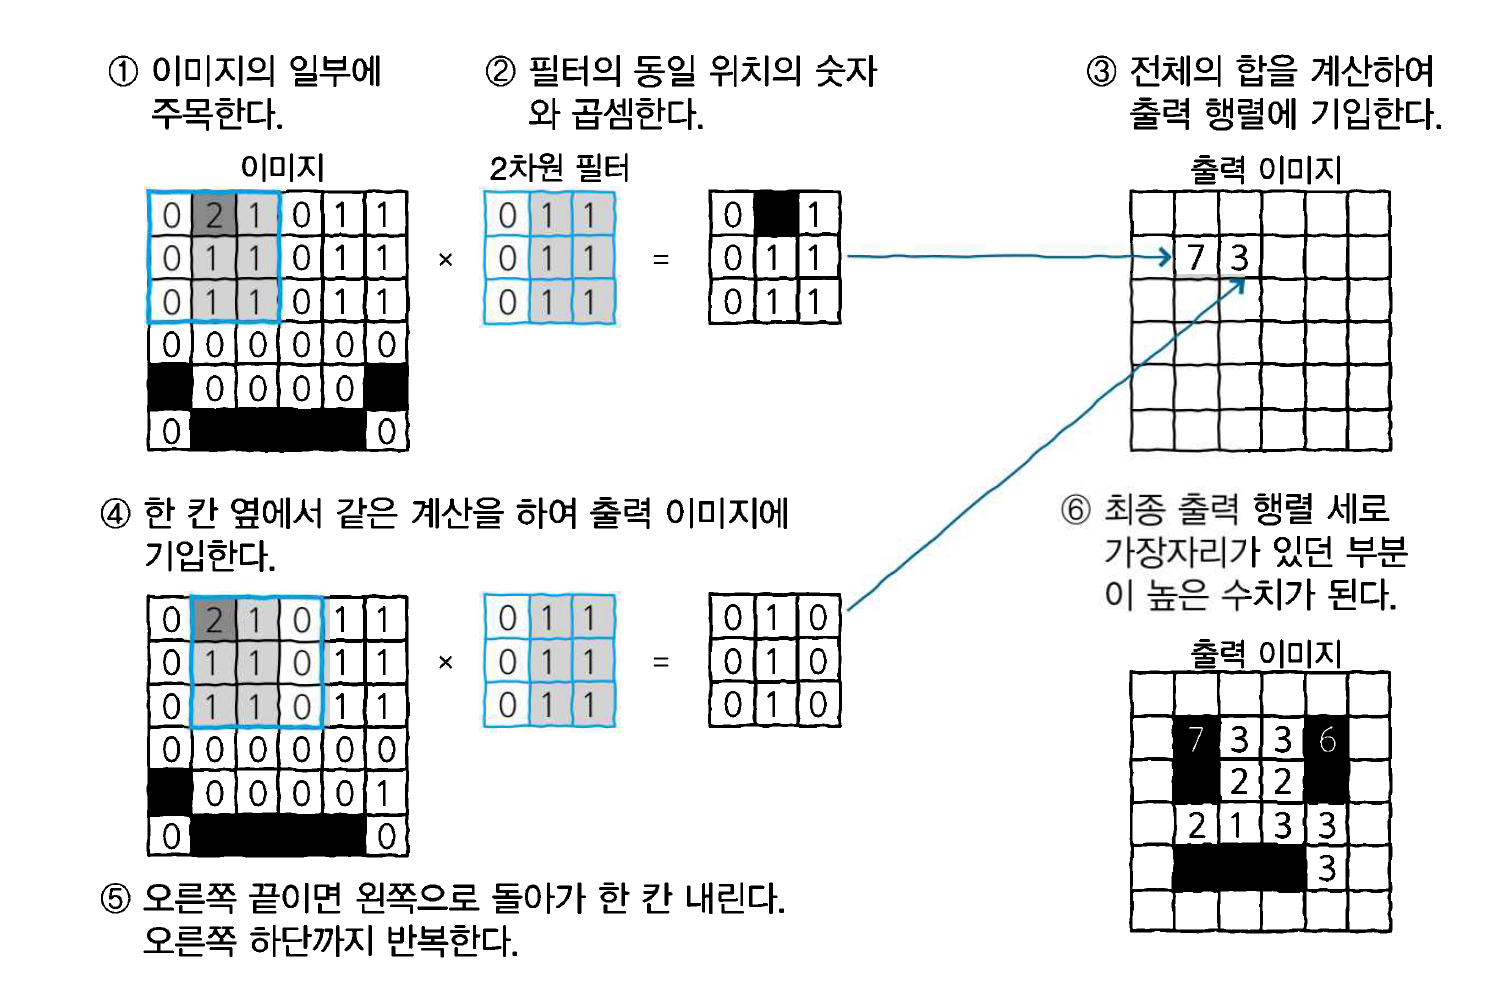

원본 이미지의 위치 (i,j)의 픽셀 값을 x(i,j), 3x3의 필터를 h(i,j)로 하면 아래와 같은 식이 나온다.

$$ g(i,j) = \sum_{u=-1}^{1}\sum_{V=-1}^{1}x(i + u, j + v)h(u+1, v+1)   $$

필터의 크기는 임의로 정할 수 있지만, 중심을 결정할 수 있는 홀수 너비가 사용하기 용이하다.

In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


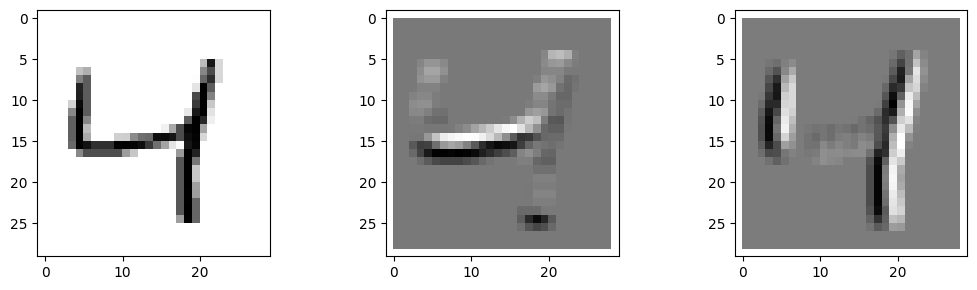

In [13]:
# 가로 및 세로 엣지를 강조하는 2개의 필터를 train dataset 2번 째인 4에 적용

import matplotlib.pyplot as plt

id_img = 2
myfil1 = np.array([[1,1,1], [1,1,1], [-2,-2,-2]], dtype=float)
myfil2 = np.array([[-2,1,1], [-2,1,1], [-2,1,1]], dtype=float)

x_img = x_train[id_img, :, :, 0]
img_h = 28
img_w = 28
x_img = x_img.reshape(img_h, img_w)
out_img1 = np.zeros_like(x_img)
out_img2 = np.zeros_like(x_img)

# 필터 처리

for ih in range(img_h -3):
  for iw in range(img_w -3):
    img_part = x_img[ih : ih + 3, iw:iw + 3]
    out_img1[ih + 1, iw + 1] = np.dot(img_part.reshape(-1), myfil1.reshape(-1))
    out_img2[ih + 1, iw + 1] = np.dot(img_part.reshape(-1), myfil2.reshape(-1))


# 표시

plt.figure(1, figsize=(12, 3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()
plt.subplot(1, 3, 1)
plt.pcolor(1 - x_img)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.subplot(1, 3, 2)
plt.pcolor(-out_img1)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.subplot(1, 3, 3)
plt.pcolor(-out_img2)
plt.xlim(-1, 29)
plt.ylim(29, -1)

plt.show()

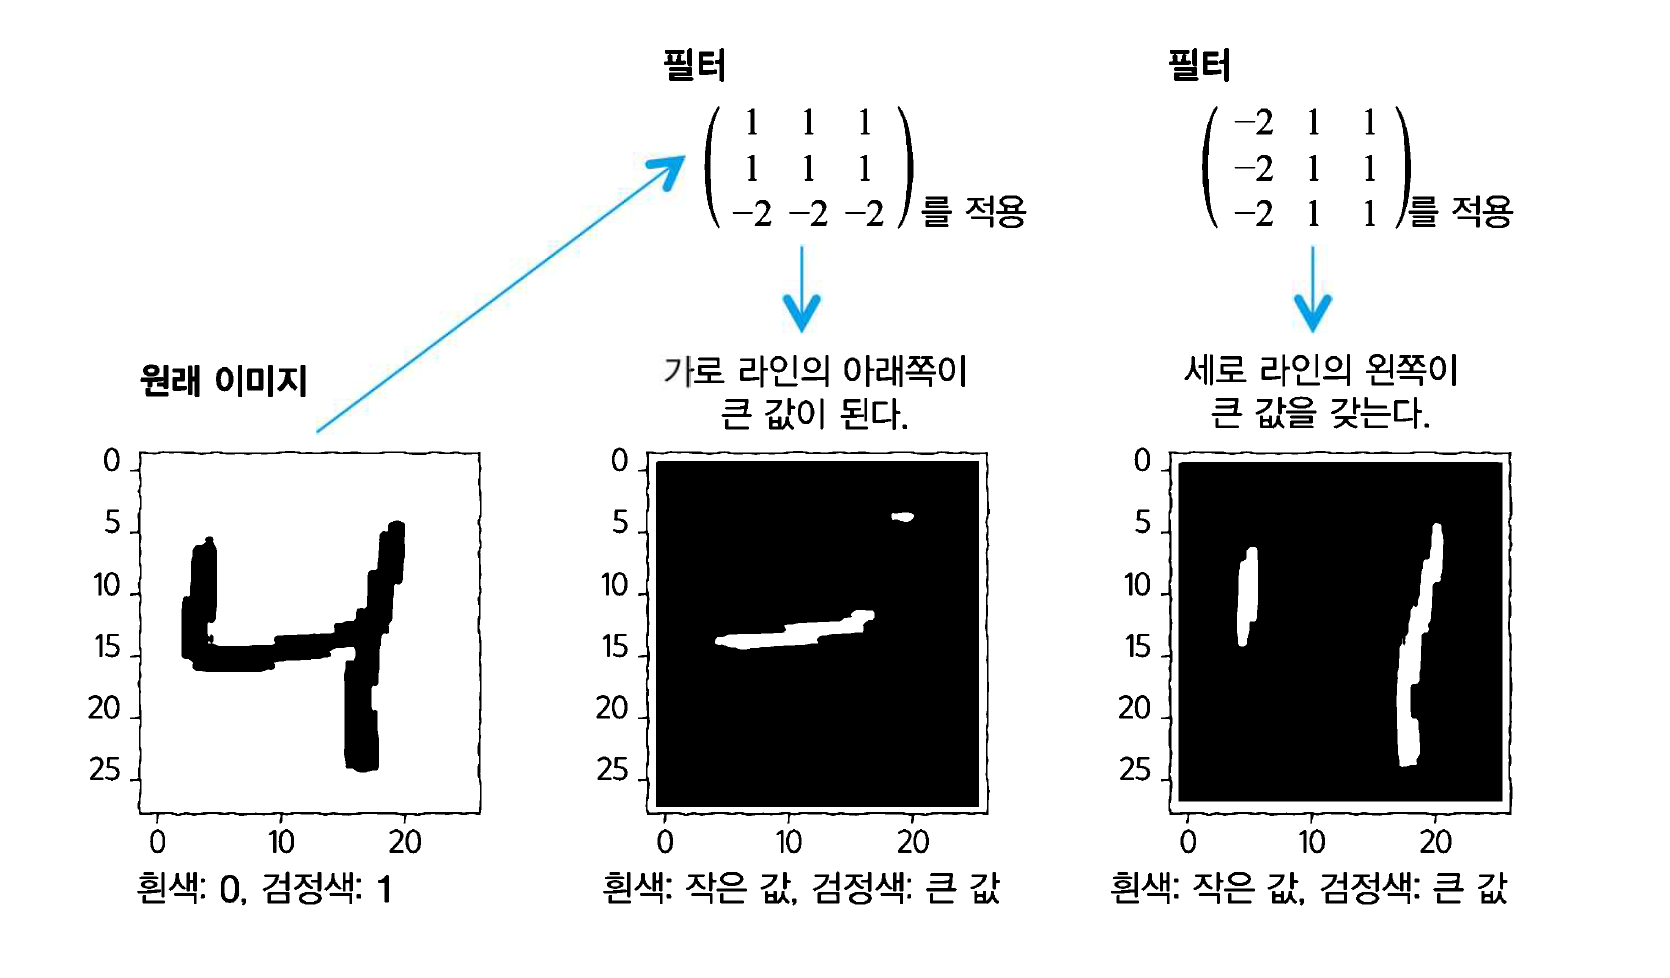

이와 같이 가로 라인의 아래쪽이 큰값이 되며, 세로 라인의 왼쪽이 큰 값을 가진다.

필터는 모든 값을 합하면 0이 되도록 디자인 되어있고, 이렇게 하면 공간 구조가 없는 균일한 부분은 0으로 변환되고, 필터에서 추출하려는 구조가 존재할 경우에는 0 이상의 값으로 변환되어, 0을 감지 레벨의 기준으로 세울 수 있어 편리하다.

필터를 사용할 경우 출력 이미지의 키기가 작아지는 것을 방지하기 위해 패딩(padding)기법을 사용한다.

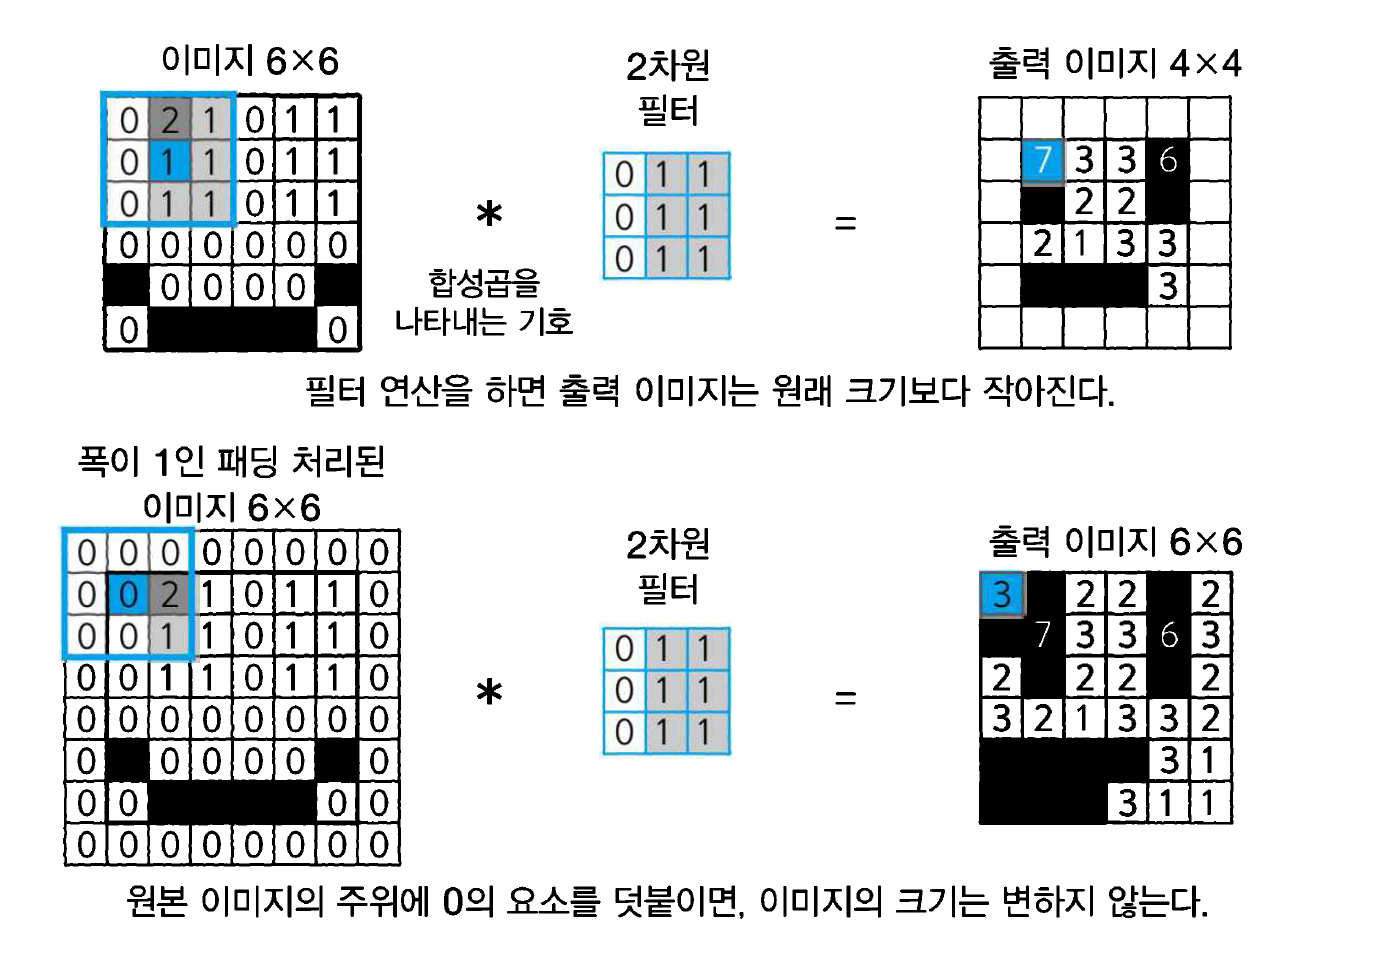

그리고 strid를 설정하여 filter가 움직이는 폭을 결정할 수 있다. (출력 이미지의 변화가 가능)


## 8.5 합성곱 신경망

CNN(Convolution neural network)

-> CNN은 필터 자체를 학습시킨다.

여기서 parameter는 입력 이미지에 대해 크기 3x3, padding = 1, stride = 1의 필터 9장을 적용한다.

1장의 필터 출력은 28 x 28 배열이므로 28 x 28 x 8의 3차원 배열이 된다. 이를 6272인 배열로 전개하고, 전 결합으로 10개의 출력층 뉴런에 결합한다.

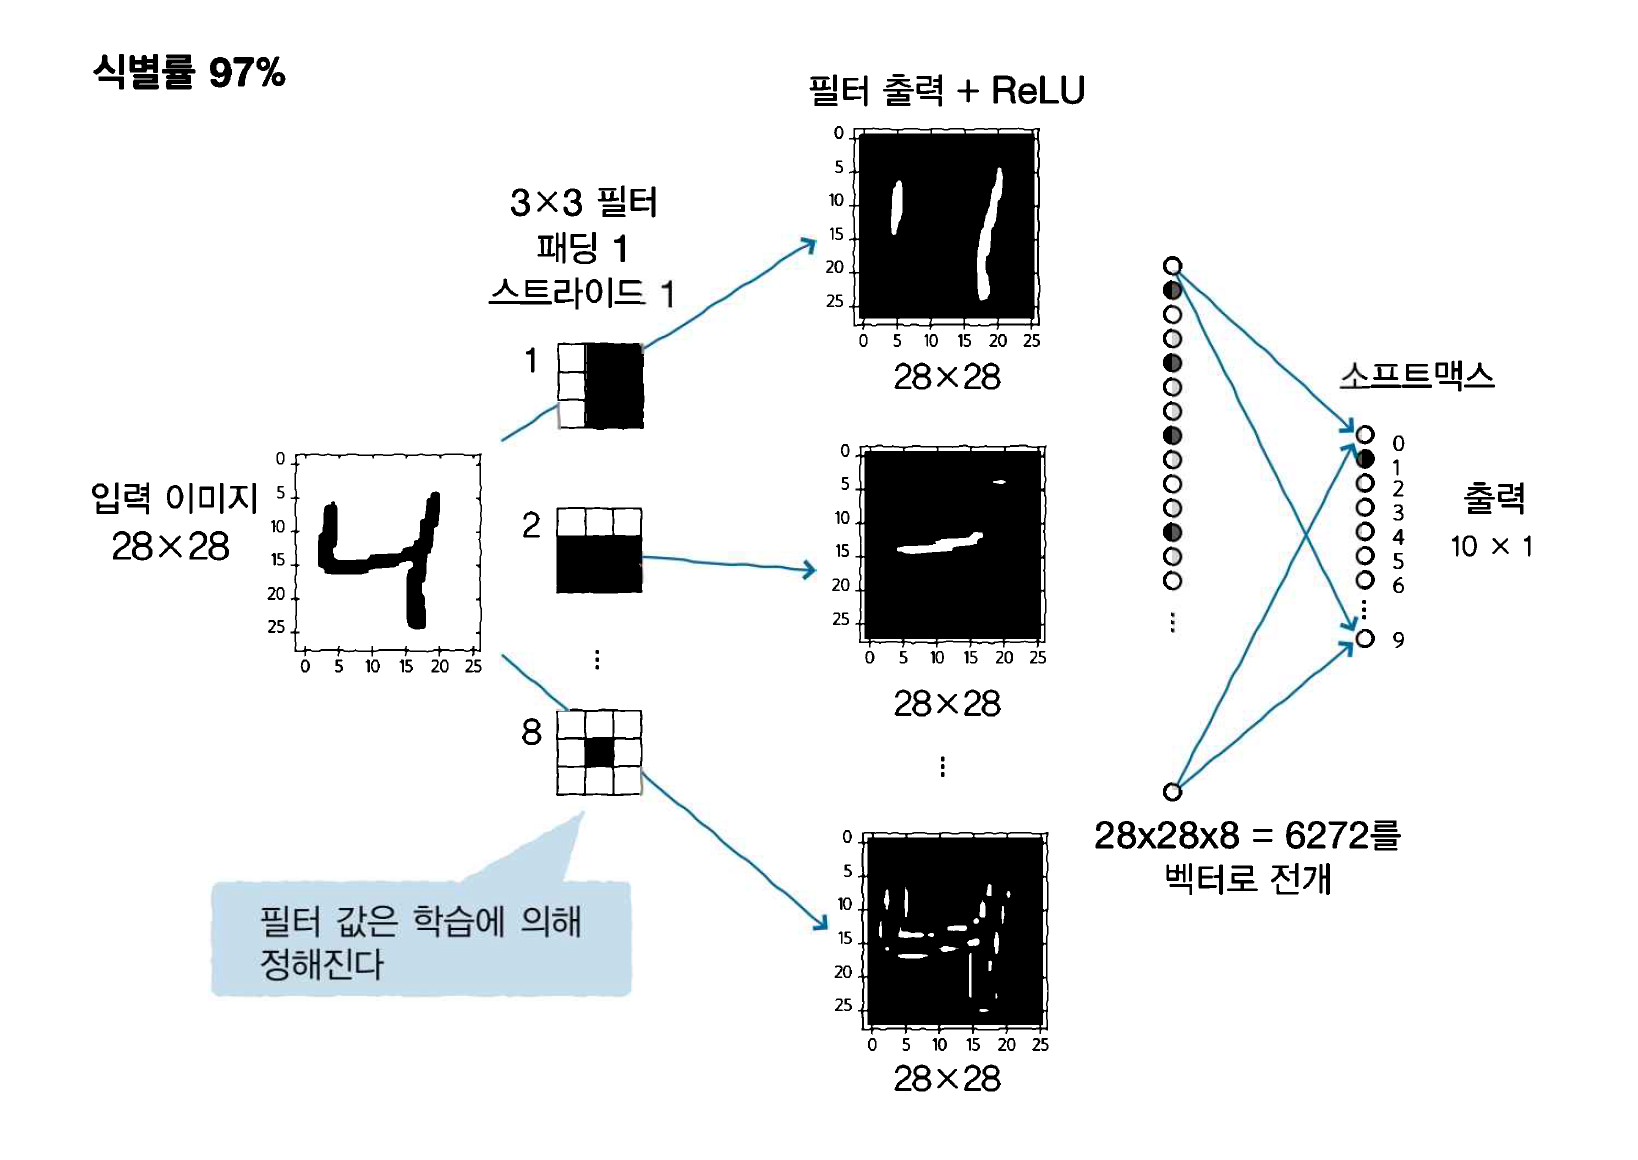

In [14]:
import numpy as np
np.random.seed(1)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
import time

model = Sequential()
# 3x3 filter 8개, padding 사용, 입력 이미지의 크기(흑백 이미지이기에 마지막은 1로 -> 0 or 1)
model.add(Conv2D(8, (3,3), padding='same', input_shape= (28, 28, 1), activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = Adam(), metrics=['accuracy'])
startTime = time.time()
history = model.fit(x_train, y_train, batch_size=1000, epochs=20, verbose=1, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy", score[1])
print("Computation time:{0:.3f}sec".format(time.time() - startTime))


Epoch 1/20
60/60 [==============================] - 13s 198ms/step - loss: 0.8437 - accuracy: 0.8009 - val_loss: 0.3478 - val_accuracy: 0.9034
Epoch 2/20
60/60 [==============================] - 9s 157ms/step - loss: 0.3186 - accuracy: 0.9087 - val_loss: 0.2697 - val_accuracy: 0.9215
Epoch 3/20
60/60 [==============================] - 10s 160ms/step - loss: 0.2620 - accuracy: 0.9258 - val_loss: 0.2358 - val_accuracy: 0.9305
Epoch 4/20
60/60 [==============================] - 10s 172ms/step - loss: 0.2232 - accuracy: 0.9368 - val_loss: 0.1998 - val_accuracy: 0.9443
Epoch 5/20
60/60 [==============================] - 10s 174ms/step - loss: 0.1903 - accuracy: 0.9462 - val_loss: 0.1755 - val_accuracy: 0.9502
Epoch 6/20
60/60 [==============================] - 9s 146ms/step - loss: 0.1635 - accuracy: 0.9541 - val_loss: 0.1512 - val_accuracy: 0.9575
Epoch 7/20
60/60 [==============================] - 10s 171ms/step - loss: 0.1416 - accuracy: 0.9610 - val_loss: 0.1356 - val_accuracy: 0.9619
E

313/313 [==============================] - 3s 9ms/step


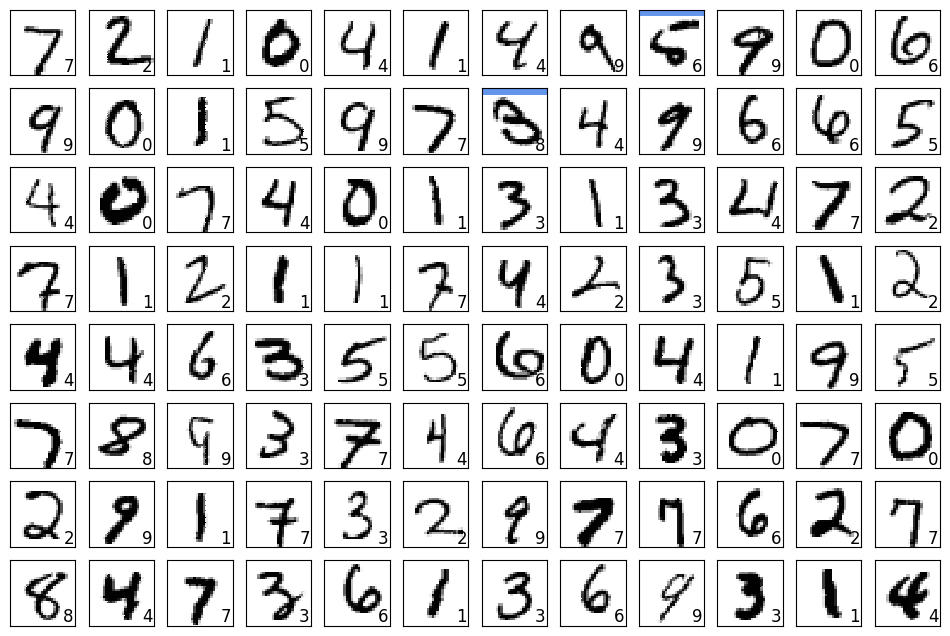

In [17]:
show_prediction()
plt.show()

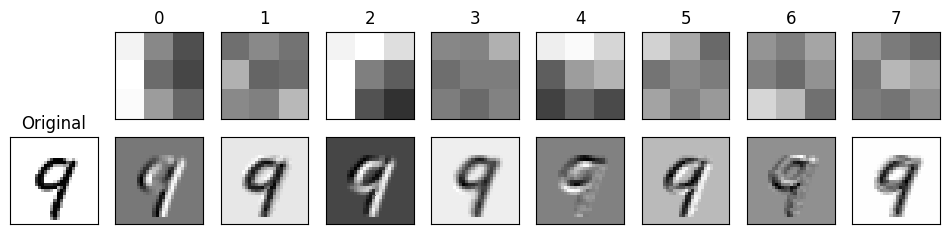

In [18]:
plt.figure(1, figsize=(12, 2.5))
plt.gray()
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.subplot(2, 9, 10)
id_img = 12
x_img = x_test[id_img, :, : , 0]
img_h = 28
img_w = 28
x_img = x_img.reshape(img_h, img_w)
plt.pcolor(-x_img)
plt.xlim(0, img_h)
plt.ylim(img_w, 0)
plt.xticks([], "")
plt.yticks([], "")
plt.title("Original")
w = model.layers[0].get_weights()[0]
max_w = np.max(w)
min_w = np.min(w)
for i in range(8):
  plt.subplot(2, 9, i + 2)
  w1 = w[:, :, 0, i]
  w1 = w1.reshape(3,3)
  plt.pcolor(-w1, vmin=min_w, vmax=max_w)
  plt.xlim(0, 3)
  plt.ylim(3, 0)
  plt.xticks([], "")
  plt.yticks([], "")
  plt.title("%d"% i)
  plt.subplot(2, 9 ,i+11)
  out_img = np.zeros_like(x_img)

  # 필터 처리
  for ih in range(img_h - 3):
    for iw in range(img_w -3):
      img_part = x_img[ih : ih+3, iw:iw + 3]
      out_img[ih+1, iw+1] = np.dot(img_part.reshape(-1), w1.reshape(-1))
  plt.pcolor(-out_img)
  plt.xlim(0, img_w)
  plt.ylim(img_h, 0)
  plt.xticks([], "")
  plt.yticks([], "")
plt.show()

학습으로 얻은 필터값을 표시하고, 9의 이미지에 각각의 필터를 적용한 이미지를 나타낸다.(작은 값은 흰색, 큰 값은 검은색으로 나타남)

## 8.6 풀링

합성곱층은 2차원 이미지가 가지는 특징을 이용할 수 있었지만, 이미지 위치의 어긋남에 대한 견고성이 필요하다.

그렇기에 나온 기법이 풀링 처리이고 입력 이미지 내의 2x2의 작은 영역에 착안하여 가장 큰 값을 출력값으로한다.

작은 공간은 스트라이드 2로 이동해 동일한 처리를 반복한다. 그 결과로 출력 이미지의 가로 세로 크기는 입력 이미지의 절반이 된다.

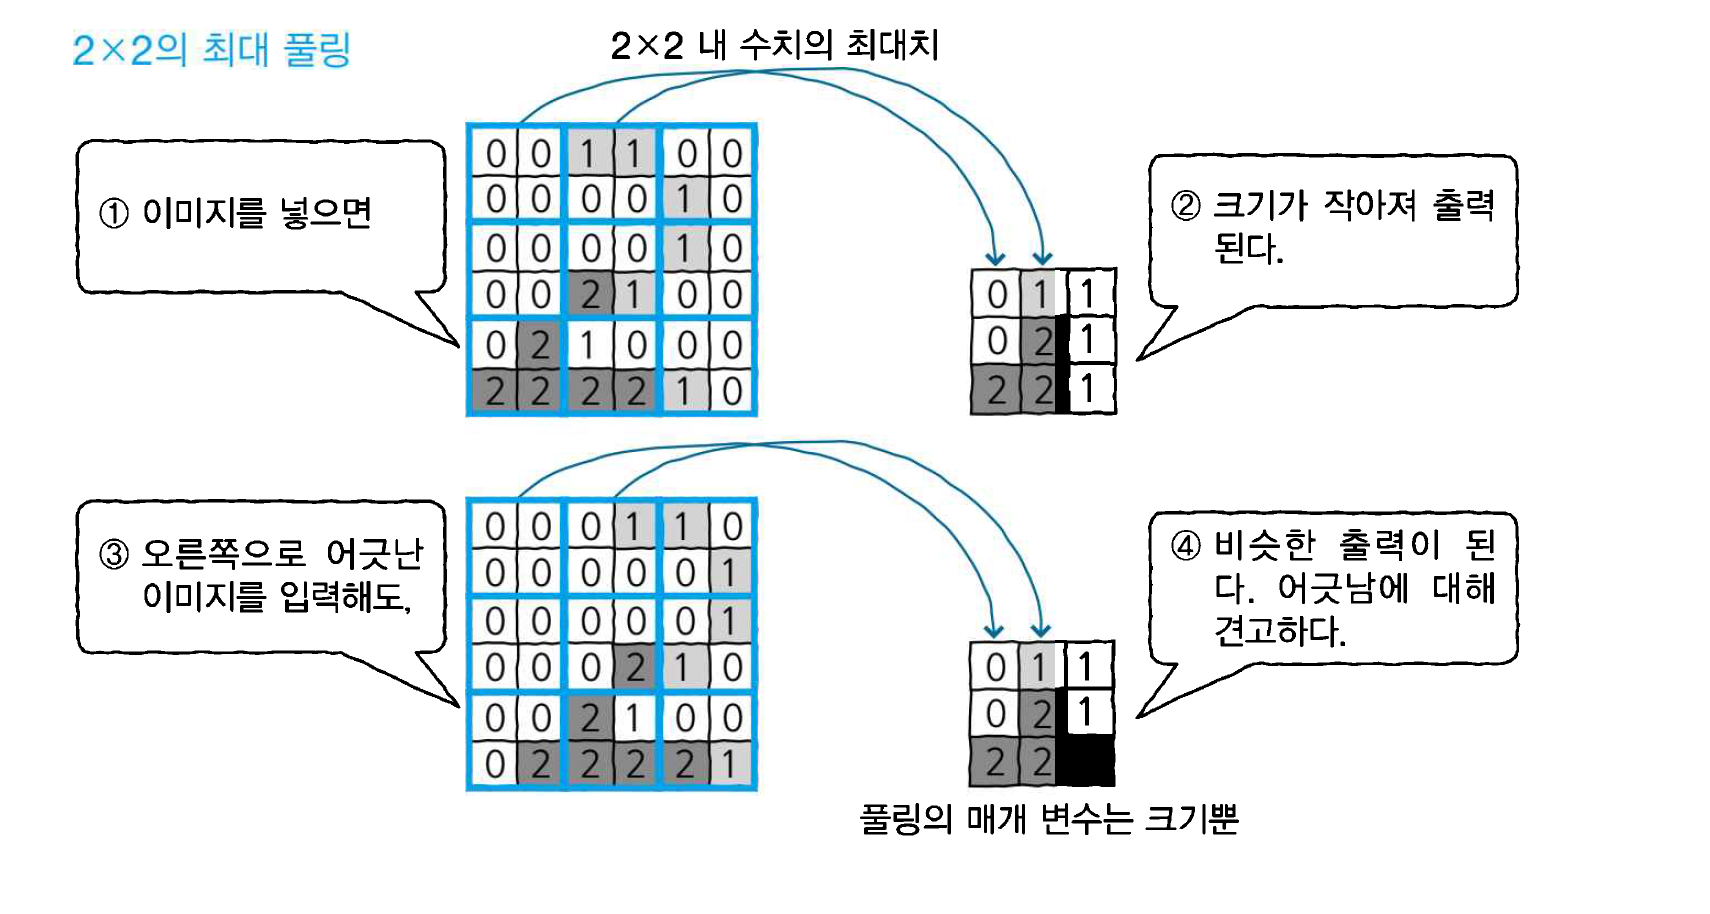

max pooling 방법 이외에 평균풀링(average pooling)이 있다.

## 8.7 드롭아웃

드롭아웃은 학습시에 입력층의 유닛과 중간층의 뉴런의 확률 p(p < 1)로 임의로 선택하여, 나머지를 무효화하는 방법입니다.

무효화화된 뉴런은 존재하지 않는 것으로 간주하여 학습을 갱신하며, 미니 배치마다 뉴런을 뽑아 다시 이 절차를 반복한다.

학습 후 예측하는 경우에는 모든 뉴런이 사용되며, 학습 시에는 p의 비율이 뉴런밖에 존재하지 않는 상태에서 학습하고 있었는데, 예측 시에 전체 참가가 되면 출력이 커져 버린다. (1/p 배)

예측 시에는 드롭아웃을 한층의 출력 대상의 가중치를 p배로 하여 작게 설정하여 계산을 맞춘다.

드롭아웃은 여러 네트워크를 각각 학습시켜 예측 시에 네트워크를 평균화해 합치는 효과가 있다.

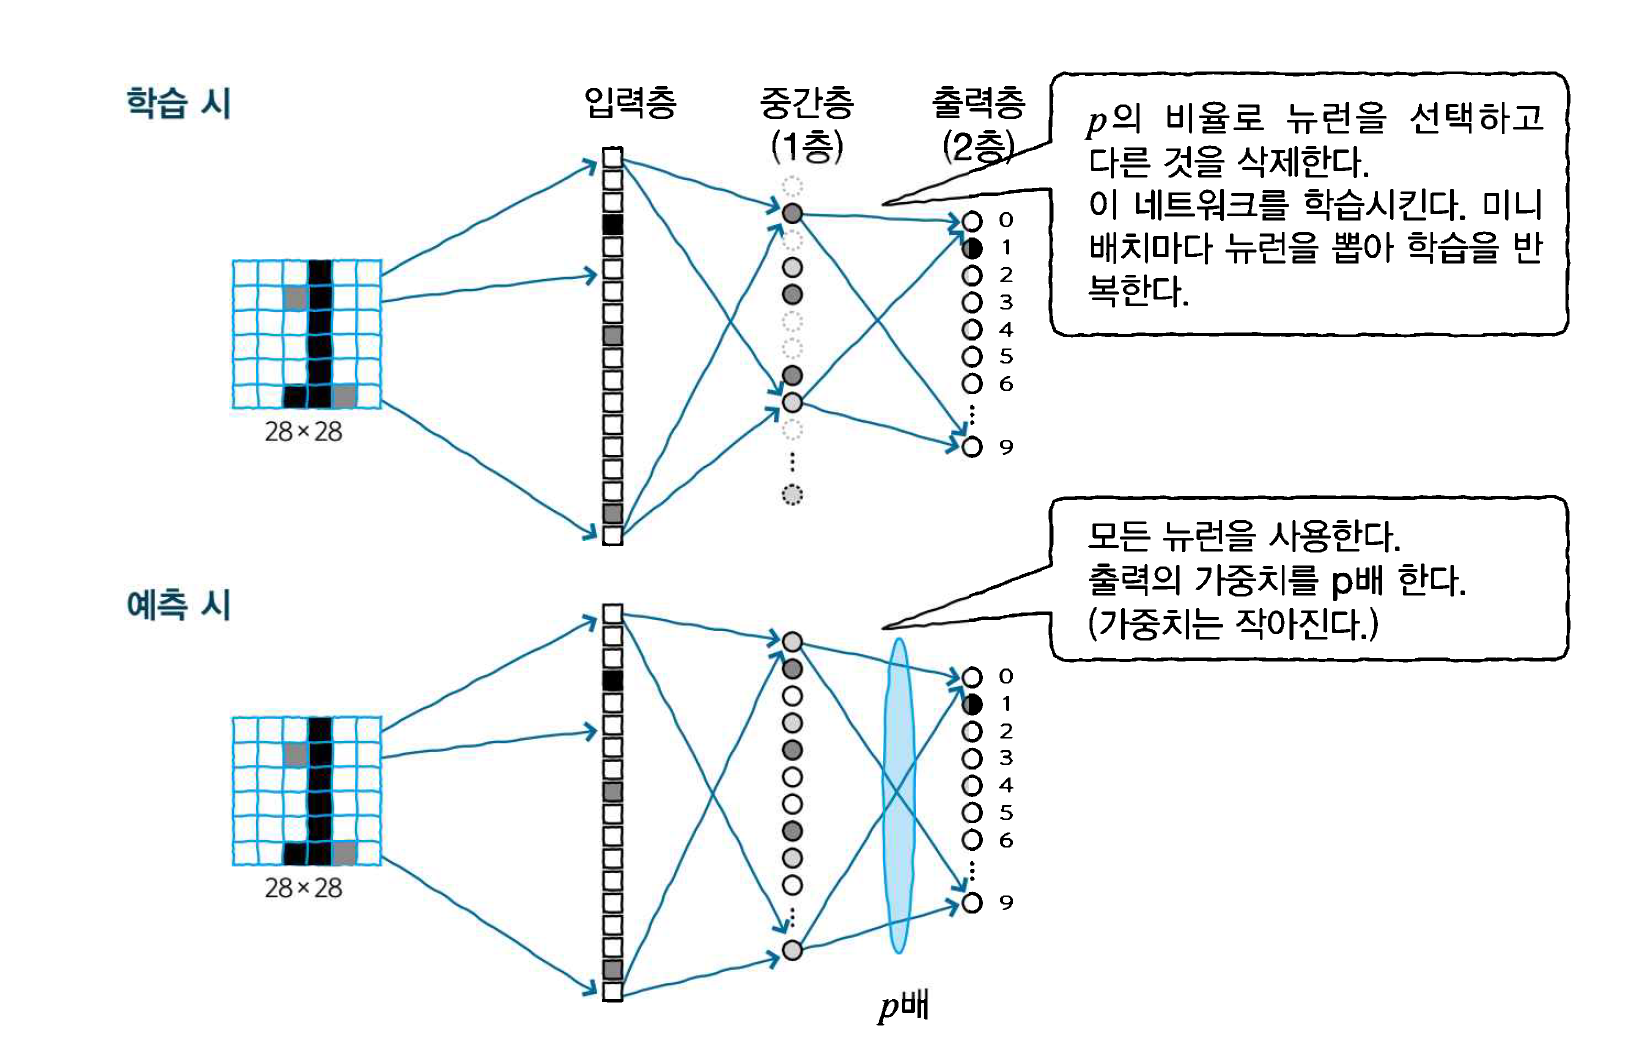

## 8.8 MNIST 인식 네트워크 모델

합성곱 네트워크에 풀링과 드롭아웃을 도입하여 계층의 수를 늘리고, 모두를 갖추고 있는 네트워크를 마지막으로 구축.

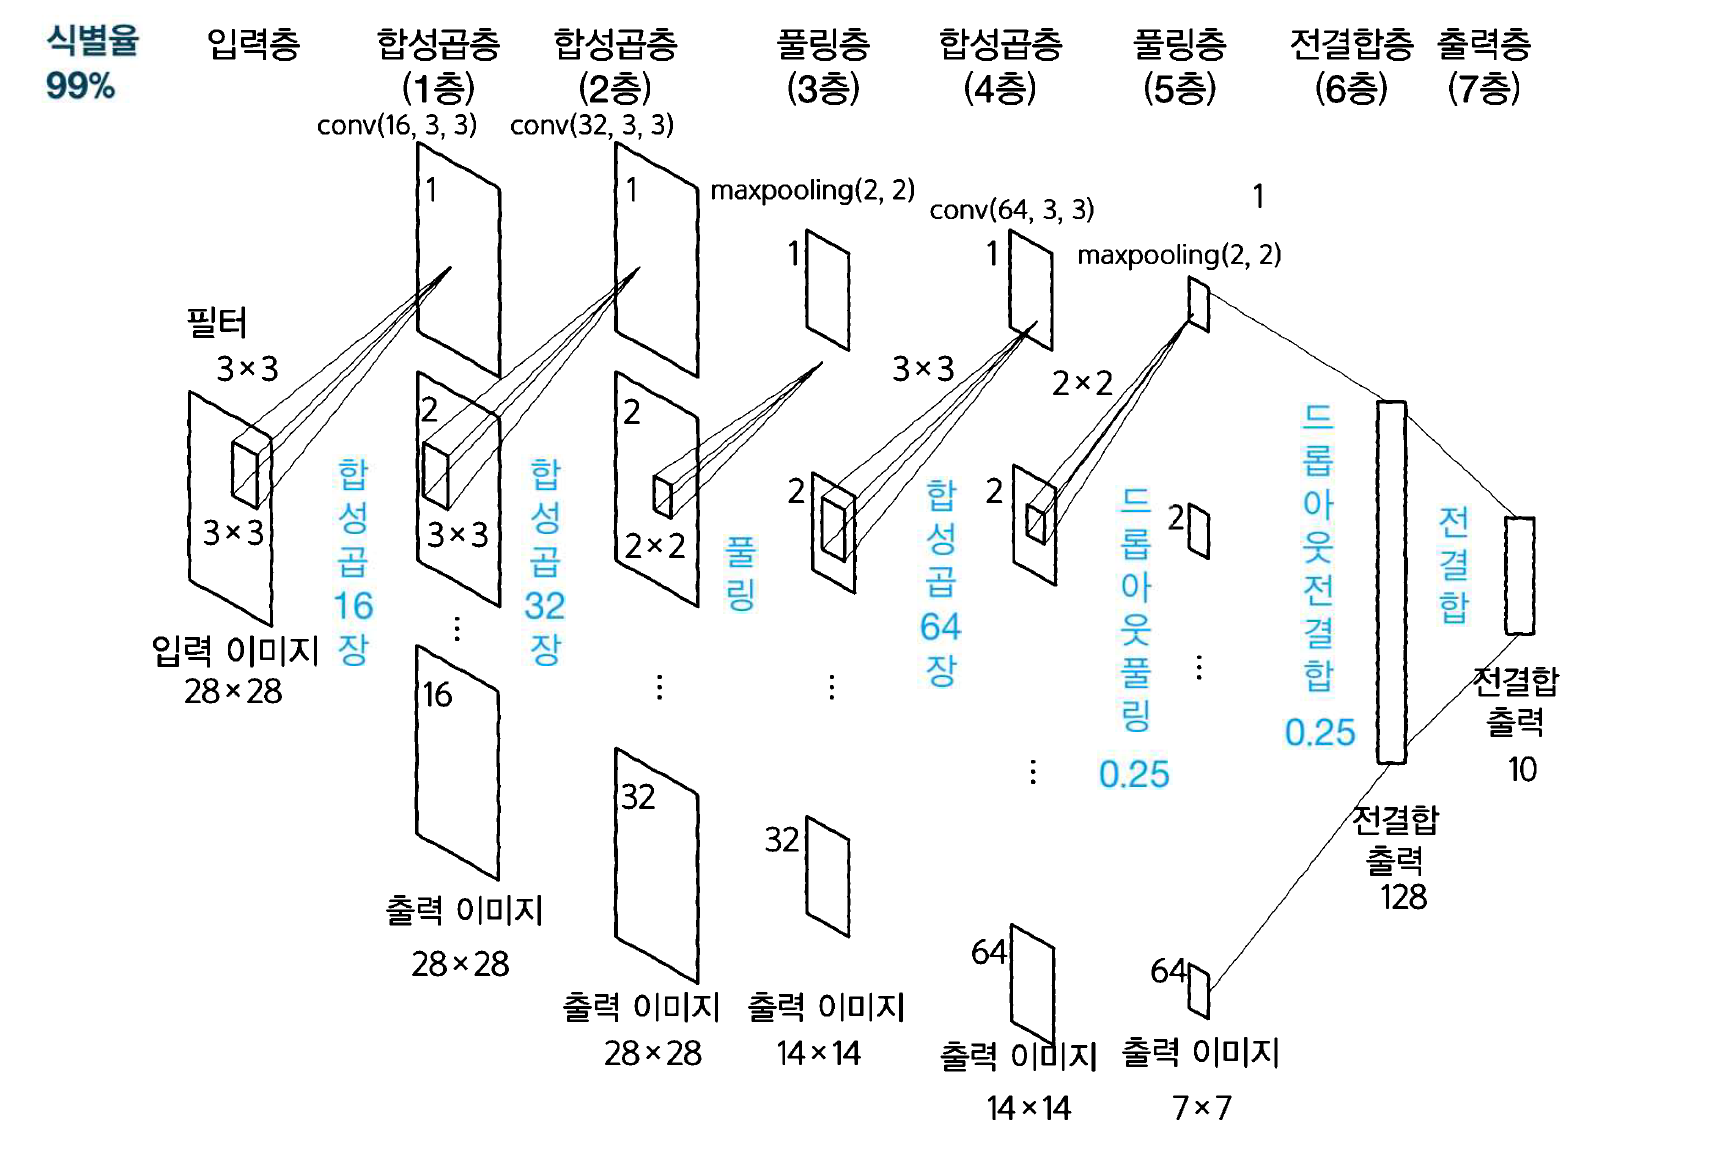

위의 그림상으로 보면 1, 2층에서 합성곱층을 연속시킨다.

1. 1층의 합성곱층은 16장의 필터를 사용하고 있기 때문에, 출력은 28 x 28의 이미지가 16장이 된다. 이것을 28 x 28 x 16의 3차원 배열의 데이터로 간주한다.

2. 다음 층의 합성곱은 3차원 배열의 데이터에 대해 수행된다. 3 x 3의 1장의 필터는 실질적으로 3 x 3 x 16의 배열로 정의된다. 출력은 28 x 28 x 16의 블록이다.이 3 x 3 x 16의 크기를 가지는 필터가 32개 있는 두 번째 레이어의 합성곱층이다. 필터를 정의하는 매개 변수의 수는 바이어스 항을 제외하면 3 x 3 x 16 x 32이 된다.

3. 3층 째는 2 x 2 맥스 풀링층으로 이미지의 가로 세로의 크기는 절반인 14 x 14이 된다.

4. 4층째에서 한 번 더 합성곱층이 온다. -> 여기서 필터의 수는 64장이다. 매개 변수의 수는 3 x 3 x 32 x 64이다.

5. 맥스 풀링에 의한 이미지 크기가 7 x 7로 된다.

6. 다음 6층에는 128개의 전결합이 이뤄진다.

7. 마지막 7층째는 출력이 10개인 전결합층이 된다.

여기서 5층과 6층에 드롭아웃이 들어간다.



In [19]:
import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
import time

model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(28,28,1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

startTime = time.time()
history = model.fit(x_train, y_train, batch_size=1000, epochs=20, verbose=1, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose= 0)
print("Test loss", score[0])
print("Test accuracy:", score[1])
print("Computation time :{0:.3f} sec".format(time.time() - startTime))

Epoch 1/20
60/60 [==============================] - 80s 1s/step - loss: 0.7803 - accuracy: 0.7654 - val_loss: 0.1512 - val_accuracy: 0.9544
Epoch 2/20
60/60 [==============================] - 74s 1s/step - loss: 0.1520 - accuracy: 0.9531 - val_loss: 0.0707 - val_accuracy: 0.9777
Epoch 3/20
60/60 [==============================] - 72s 1s/step - loss: 0.0992 - accuracy: 0.9700 - val_loss: 0.0607 - val_accuracy: 0.9793
Epoch 4/20
60/60 [==============================] - 72s 1s/step - loss: 0.0765 - accuracy: 0.9765 - val_loss: 0.0417 - val_accuracy: 0.9868
Epoch 5/20
60/60 [==============================] - 69s 1s/step - loss: 0.0623 - accuracy: 0.9809 - val_loss: 0.0359 - val_accuracy: 0.9884
Epoch 6/20
60/60 [==============================] - 72s 1s/step - loss: 0.0547 - accuracy: 0.9832 - val_loss: 0.0324 - val_accuracy: 0.9895
Epoch 7/20
60/60 [==============================] - 71s 1s/step - loss: 0.0466 - accuracy: 0.9854 - val_loss: 0.0287 - val_accuracy: 0.9911
Epoch 8/20
60/60 [==

313/313 [==============================] - 5s 15ms/step


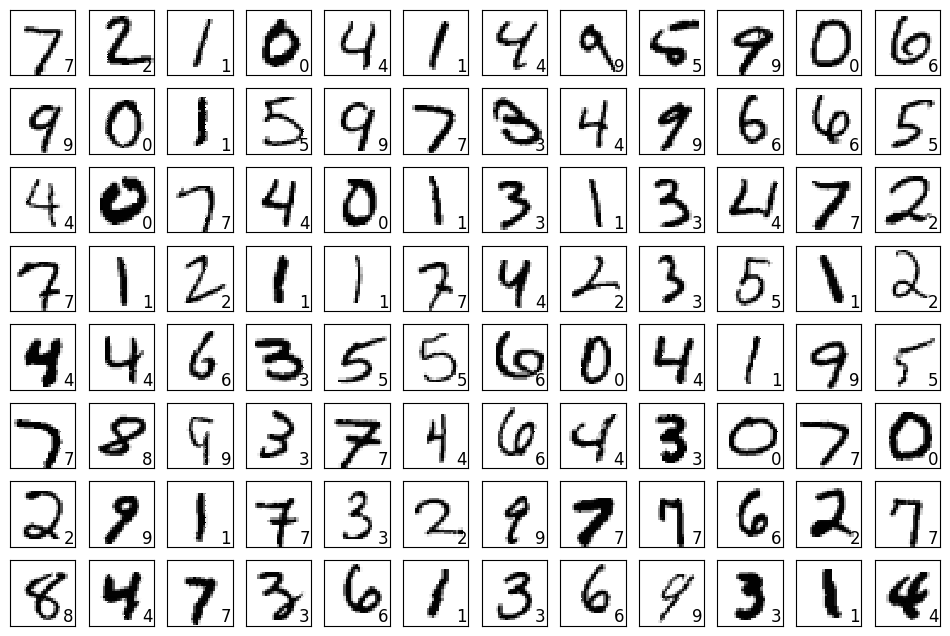

In [20]:
# 테스트 데이터 예측 예를 표시

show_prediction()
plt.show()

앞으로는 단순하며 정확한 (acc 가 높은) 네트워크를 만드는 것이 필요하며, 더큰 크기의 자연의 이미지를 처리하거나 많은 카테고리를 다루는 경우에 심층화, 합성곱, 풀링, 드롭아웃의 효과가 더욱 강력하게 발휘될 것이다.